In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import os
import logging
import matplotlib.pyplot as plt
import random
import cv2
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Encoder(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.enc1 = DoubleConv(in_channels, 64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)
        self.enc4 = DoubleConv(256, 512)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))
        return enc1, enc2, enc3, enc4

class Bottleneck(nn.Module):
    def __init__(self):
        super().__init__()
        self.bottleneck = nn.Sequential(
            nn.MaxPool2d(2, 2),
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.bottleneck(x)

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.upconv4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = DoubleConv(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = DoubleConv(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = DoubleConv(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = DoubleConv(128, 64)

    def forward(self, bottleneck, skip1, skip2, skip3, skip4):
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat([dec4, skip4], dim=1)
        dec4 = self.dec4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat([dec3, skip3], dim=1)
        dec3 = self.dec3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat([dec2, skip2], dim=1)
        dec2 = self.dec2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat([dec1, skip1], dim=1)
        dec1 = self.dec1(dec1)
        return dec1

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):  # Ubah ke 1 channel
        super().__init__()
        self.encoder = Encoder(in_channels)
        self.bottleneck = Bottleneck()
        self.decoder = Decoder()
        self.final_conv = nn.Conv2d(64, out_channels, 1)

    def forward(self, x):
        skip1, skip2, skip3, skip4 = self.encoder(x)
        bottleneck = self.bottleneck(skip4)
        decoded = self.decoder(bottleneck, skip1, skip2, skip3, skip4)
        return self.final_conv(decoded)

<ipython-input-9-e203c255184d>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=self.device)


Model loaded successfully. Using device: cuda
Metrics - PSNR: 35.41 dB, SSIM: 0.973


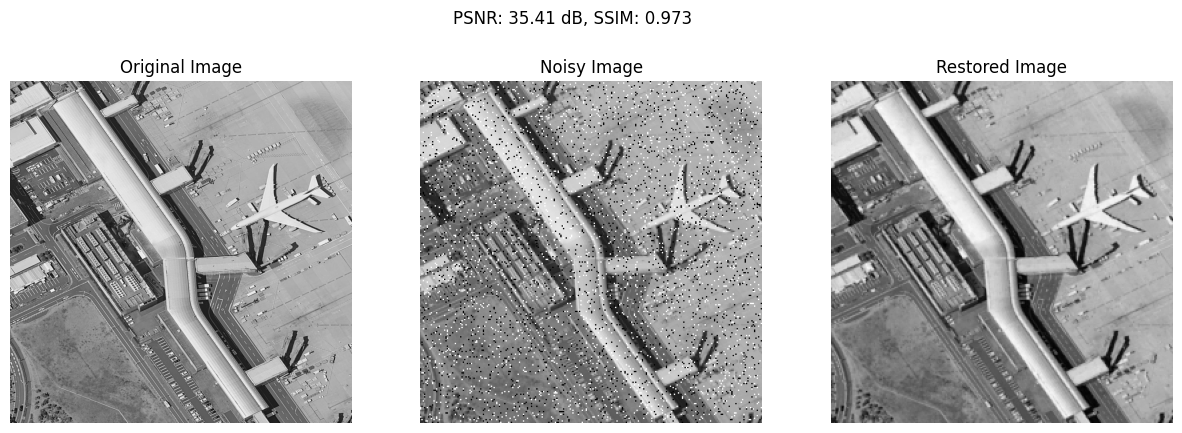

In [ ]:
class ModelLoader:
    def __init__(self, model_path, image_size=(256, 256)):
        """
        Initialize ModelLoader with model path and optional image size.

        Args:
            model_path (str): Path to the model checkpoint
            image_size (tuple): Target image size for processing (default: (256, 256))
        """
        self.image_size = image_size
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = self._load_model(model_path)
        self.transform = self._get_transforms()
        print(f"Model loaded successfully. Using device: {self.device}")

    def _load_model(self, model_path):
        """Load model from checkpoint."""
        if not os.path.exists(model_path):
            raise FileNotFoundError(f"Model file not found at: {model_path}")

        model = UNet()  # Assuming UNet is imported properly
        checkpoint = torch.load(model_path, map_location=self.device)

        if 'model_state_dict' not in checkpoint:
            raise KeyError("Checkpoint does not contain 'model_state_dict'")

        model.load_state_dict(checkpoint['model_state_dict'], strict=False)
        model = model.to(self.device)
        model.eval()
        return model

    def _get_transforms(self):
        """Get image transformation pipeline."""
        return transforms.Compose([
            transforms.Resize(self.image_size),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x.to(self.device))
        ])

    def _add_noise(self, image_tensor, noise_type='random', noise_params=None):
        """
        Add noise to the image tensor.

        Args:
            image_tensor (torch.Tensor): Input image tensor
            noise_type (str): Type of noise ('random', 'gaussian', 'salt_pepper', 'speckle')
            noise_params (dict, optional): Custom noise parameters
        """
        if noise_params is None:
            noise_params = {
                'gaussian': {'mean': 0, 'sigma_range': (0.02, 0.1)},
                'salt_pepper': {'prob_range': (0.02, 0.1)},
                'speckle': {'intensity_range': (0.05, 0.2)}
            }

        # Jika noise_type adalah string, gunakan sebagai tipe noise
        if isinstance(noise_type, str):
            if noise_type == 'random':
                noise_type = random.choice(['gaussian', 'salt_pepper', 'speckle'])
            elif noise_type not in ['gaussian', 'salt_pepper', 'speckle']:
                raise ValueError(f"Unsupported noise type: {noise_type}")

        if noise_type == 'gaussian':
            sigma = random.uniform(*noise_params['gaussian']['sigma_range'])
            noise = torch.normal(noise_params['gaussian']['mean'], sigma,
                              image_tensor.shape, device=self.device)
            noisy_image = image_tensor + noise

        elif noise_type == 'salt_pepper':
            prob = random.uniform(*noise_params['salt_pepper']['prob_range'])
            noise = torch.rand(image_tensor.shape, device=self.device)
            salt = (noise > 1 - prob/2).float()
            pepper = (noise < prob/2).float()
            noisy_image = image_tensor * (1 - salt - pepper) + salt

        else:  # speckle noise
            intensity = random.uniform(*noise_params['speckle']['intensity_range'])
            noise = torch.randn(image_tensor.shape, device=self.device) * intensity
            noisy_image = image_tensor + image_tensor * noise

        return torch.clamp(noisy_image, 0, 1)

    def _calculate_metrics(self, original, restored):
        """
        Calculate image quality metrics.

        Returns:
            dict: Dictionary containing MSE, PSNR, and SSIM values
        """
        metrics = {
            'mse': mean_squared_error(original, restored),
            'psnr': float(cv2.PSNR(original, restored)),
            'ssim': float(ssim(original, restored, full=False))
        }
        return metrics

    def restore_image(self, image_path, output_path=None):
        """
        Restore image from noise and optionally save results.

        Args:
            image_path (str): Path to input image
            output_path (str, optional): Path to save restored image

        Returns:
            tuple: (noisy_image, restored_image, metrics)
        """
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image file not found at: {image_path}")

        # Load and preprocess image
        img = Image.open(image_path).convert('L')
        img_tensor = self.transform(img)

        # Add noise
        noisy_tensor = self._add_noise(img_tensor, noise_type='salt_pepper')

        # Add batch dimension
        noisy_tensor = noisy_tensor.unsqueeze(0)

        # Inference
        with torch.no_grad():
            restored = self.model(noisy_tensor)

        # Post-processing
        restored_img = (restored.squeeze().cpu().numpy() * 255).astype(np.uint8)
        original_img = (img_tensor.squeeze().cpu().numpy() * 255).astype(np.uint8)
        noisy_img = (noisy_tensor.squeeze().cpu().numpy() * 255).astype(np.uint8)

        # Calculate metrics
        metrics = self._calculate_metrics(original_img, restored_img)

        # Save results if output path is provided
        if output_path:
            output_dir = os.path.dirname(output_path)
            if not os.path.exists(output_dir):
                os.makedirs(output_dir)

            Image.fromarray(restored_img).save(output_path)
            noisy_path = output_path.replace('.jpg', '_noisy.jpg')
            Image.fromarray(noisy_img).save(noisy_path)

        return noisy_img, restored_img, metrics

    def visualize_restoration(self, image_path, save_plot=False, plot_path=None):
        """
        Visualize original, noisy, and restored images side by side.

        Args:
            image_path (str): Path to input image
            save_plot (bool): Whether to save the plot
            plot_path (str, optional): Path to save the plot
        """
        noisy_img, restored_img, metrics = self.restore_image(image_path)
        original_img = np.array(Image.open(image_path).convert('L'))

        print(f"Metrics - PSNR: {metrics['psnr']:.2f} dB, SSIM: {metrics['ssim']:.3f}")

        plt.figure(figsize=(15, 5))

        images = [original_img, noisy_img, restored_img]
        titles = ['Original Image', 'Noisy Image', 'Restored Image']

        for i, (img, title) in enumerate(zip(images, titles), 1):
            plt.subplot(1, 3, i)
            plt.imshow(img, cmap='gray')
            plt.title(title)
            plt.axis('off')

        plt.suptitle(f"PSNR: {metrics['psnr']:.2f} dB, SSIM: {metrics['ssim']:.3f}")

        if save_plot and plot_path:
            plt.savefig(plot_path, bbox_inches='tight', dpi=300)

        plt.show()

if __name__ == "__main__":
    # Initialize model
    model_path = '/content/drive/MyDrive/Dataset/satellit_dataset/model_saves/best_model.pth'
    model_loader = ModelLoader(model_path)

    input_path = '/content/image-4.jpg'
    output_dir = '/content/drive/MyDrive/Dataset/satellit_dataset/model_output/'

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    output_path = os.path.join(output_dir, os.path.basename(input_path))
    plot_path = os.path.join(output_dir, 'restoration_plot.png')

    # Process single image
    model_loader.restore_image(input_path, output_path)
    model_loader.visualize_restoration(input_path, save_plot=True, plot_path=plot_path)